In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
np.random.seed(0)

# Dataset

In [2]:
n_tasks = 10
n_samples = 1000
n_features = 2

datasets = []
for i in range(n_tasks):
    mean1 = np.random.randn(2)
    mean2 = np.random.randn(2)
    cov = np.random.randn(2, 2)
    X1 = np.random.multivariate_normal(mean1, cov.T @ cov, n_samples)
    X2 = np.random.multivariate_normal(mean2, cov.T @ cov, n_samples)
    
    # Combine the data and create labels
    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))
    dataset = np.hstack((X, y.reshape(len(y), 1)))
    np.random.shuffle(dataset)
    n = len(dataset)
    dtrain = dataset[: int(0.8 * n)]
    dvalid = dataset[: int(0.2 * n)]
    datasets.append((dtrain, dvalid))

# Operations

In [3]:
def identity_func(x: object):
    return x

func_indices = [0, 1, 2, 3]
functions = [identity_func, np.add, np.abs, np.matmul]

# Pool of variables 

In [4]:
class Pool:
    def __init__(self, num_of_scalars : int, num_of_vectors : int): # для простоты только векторы и скаляры
        self.num_of_scalars = num_of_scalars
        self.num_of_vectors = num_of_vectors
        self.scalars = np.zeros(num_of_scalars)
        self.scalars_state = np.ones(num_of_scalars, dtype=bool)
        self.vectors = np.zeros(shape=(num_of_vectors, 2))
        self.vectors_state = np.ones(num_of_vectors, dtype=bool)

        
    def get_scalar_index_available(self):
        for i in range(3):
            if self.scalars_state[i]:
                return i 
        return -1 # no available scalars
            
    def get_vector_index_available(self):
        for i in range(3):
            if self.vectors_state[i]:
                return i 
        return -1 # no available vectors
            
    def set_scalar(self, index: int, value: int):
        self.scalars[index] = value 
        self.scalars_state[index] = False 
        
    def set_vector(self, index: int, value: np.array):
        self.vectors[index] = value 
        self.vectors_state[index] = False 
        
    def set_scalars(self, values: np.array):
        assert values.shape == self.scalars.shape
        self.scalars = values 
        
    def set_vectors(self, values: np.array):
        assert values.shape == self.vectors.shape
        self.vectors = values
        
    def get_scalar(self, index: int):
        return self.scalars[index]
    
    def get_scalars(self, indices: list = None):
        if indices is None:
            return self.scalars
        return self.scalars[indices]
    
    def is_scalar_available(self, index: int):
        return self.scalars_state[index]
    
    def is_vector_available(self, index: int):
        return self.vectors_state[index]
    
    def get_vector(self, index: int):
        return self.vectors[index]
    
    def get_vectors(self, indices: list = None):
        if indices is None:
            return self.vectors 
        return self.vectors[indices]

    def __repr__(self):
        return f"Pool(\nscalars={self.scalars}, \nvectors=\n{self.vectors}\n)"

# Functions

## Abstract Function

In [5]:
class Function(ABC):
    @abstractmethod
    def eval_func(self):
        pass
    
    @abstractmethod
    def add_function(self, new_func):
        pass 
    
    @abstractmethod
    def remove_function(self, func_index: int):
        pass 
    
    @abstractmethod
    def replace_function(self, func_index: int):
        pass 
    
    @abstractmethod
    def change_inner_params(self, func_index: int):
        pass 

## Setup

In [6]:
class Setup(Function, ABC):
    def __init__(self):
        self.functions = [np.random.randn] 
        self.current_func_index = 0
        
    def replace_function(self, func_index: int):
        # self.current_func_index = np.random.choice([0, 1])
        pass 
    
    def add_function(self, new_func):
        self.replace_function(-1)
    
    def remove_function(self, func_index: int):
        self.replace_function(-1)
        
    def change_inner_params(self, func_index: int):
        self.replace_function(-1)
    
    def eval_func(self):
        func = self.functions[self.current_func_index]
        pool.set_scalars(func(num_of_scalars))
        pool.set_vectors(func(num_of_vectors, 2))
    

## Learn

In [7]:
class Learn(Function, ABC):
    def __init__(self):
        self.functions = [] # list of functions
        self.func_args = [] # list of tuples (var_type, [memory_indices])
        self._predict_index = 1 # s1 
        self._label_index = 0 # s0 
        
    def add_function(self, func_type):
        self.functions.append(func_type)
        var_type = -1
        return_type = -1
        arg_indices = []
        return_index = -1
        if func_type == 0: 
            var_type = np.random.choice([0, 1]) # 0 - scalar, 1 - vector
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 1:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 2: 
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 3: 
            var_type = 1
            return_type = 0
            arg_indices = np.random.choice(np.arange(num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars), size=1)
            
        self.func_args.append(dict(
            var_type=var_type, 
            return_type=return_type,
            arg_indices=arg_indices,
            return_index=return_index
            )
        )
        
    def change_inner_params(self, func_index: int):
        func_type = self.functions[func_index]
        var_type = self.func_args[func_index]["var_type"]
        return_type = self.func_args[func_index]["return_type"]
        arg_size = None
        
        if func_type == 0:
            arg_size = 1
        elif func_type == 1:
            arg_size = 2
        elif func_type == 2:
            arg_size = 1
        elif func_type == 3:
            arg_size = 2
            
        self.func_args[func_index]["arg_indices"] = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=arg_size)
        self.func_args[func_index]["return_index"] = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)


    
    def remove_function(self, func_index: int):
        del self.func_args[func_index]
        del self.functions[func_index]

    def replace_function(self, func_index: int):
        func_type = np.random.choice([0, 1, 2, 3])
        var_type = -1
        return_type = -1
        arg_indices = []
        return_index = -1
        if func_type == 0:
            var_type = np.random.choice([0, 1]) # 0 - scalar, 1 - vector
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 1:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 2:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 3:
            var_type = 1
            return_type = 0
            arg_indices = np.random.choice(np.arange(num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars), size=1)
            
        self.functions[func_index] = func_type
        self.func_args[func_index] = dict(
            var_type=var_type, 
            return_type=return_type,
            arg_indices=arg_indices,
            return_index=return_index
        )

    def eval_func(self):
        for func_index, args in zip(self.functions, self.func_args):
            var_type = args["var_type"]
            return_type = args["return_type"]
            arg_indices = args["arg_indices"]
            return_index = args["return_index"]
            
            result = None
            if var_type == 0:
                result = functions[func_index](*pool.get_scalars(arg_indices))
            elif var_type == 1:
                result = functions[func_index](*pool.get_vectors(arg_indices))
                
            if return_type == 0:
                pool.set_scalar(index=return_index, value=result)
            elif return_type == 1:
                pool.set_vector(index=return_index, value=result)
            

## Predict

In [8]:
class Predict(Learn, ABC):
    pass

# Mutator

In [9]:
class Mutator:
    def __init__(self):
        self.mutate_types = [
            "add_function", 
            "remove_function", 
            "change_function", 
            "change_inner_params"
        ]
        self._added = False
        self._critical_func_nums = 10
        
        
    def mutate(self, function: Function):
        mutation_type = np.random.choice(self.mutate_types)
        # mutation_type = "change_function"
        if not self._added:
            mutation_type = "add_function"
            self._added = True
            
        if len(function.functions) >= self._critical_func_nums:
            mutation_type = np.random.choice(self.mutate_types[1:])
            
        if mutation_type == "add_function":
            function_index = np.random.choice([0, 1, 2, 3])
            function.add_function(function_index)
        elif mutation_type == "remove_function":
            if len(function.functions) > 0:
                function.remove_function(np.random.choice(np.arange(len(function.functions))))
        elif mutation_type == "change_function":
            if len(function.functions) > 0:
                function.replace_function(np.random.choice(np.arange(len(function.functions))))
        elif mutation_type == "change_inner_params":
            if len(function.functions) > 0:
                function.change_inner_params(np.random.choice(np.arange(len(function.functions))))
            
        return function
            

# Evaluate function

In [10]:
def initialize_memory():
    pool.set_scalars(np.zeros(num_of_scalars))
    pool.set_vectors(np.zeros((num_of_vectors, 2)))
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def normalize(x):
    return sigmoid(x)

def loss(true, predicted):
    return (predicted >= 0.5) == true
    
def evaluate_one_task(setup: Setup, predict: Predict, learn: Learn, dtrain, dvalid):
    initialize_memory()
    setup.eval_func()
    for row in dtrain:
        x = row[:-1]
        y = row[-1]
        pool.set_vector(index=0, value=x)
        predict.eval_func()
        s1 = pool.get_scalar(index=0)
        pool.set_scalar(index=1, value=normalize(s1))
        pool.set_scalar(index=0, value=y)
        learn.eval_func()
    
    sum_loss = 0.0
    for row in dvalid:
        x = row[:-1]
        y = row[-1]
        pool.set_vector(index=0, value=x)
        predict.eval_func()
        s1 = pool.get_scalar(index=1)
        pool.set_scalar(index=1, value=normalize(s1))
        sum_loss += loss(y, s1)
        
    mean_loss = sum_loss / len(dvalid)
    return mean_loss

def evaluate(setup: Setup, predict: Predict, learn: Learn):
    mean_loss = 0.0
    for dtrain, dvalid in datasets:
        mean_loss += evaluate_one_task(setup, predict, learn, dtrain, dvalid)
    return mean_loss / n_tasks

def get_best_model(models):
    best_model = models[0]
    for i in range(len(models)):
        if models[i][3] < best_model[3]:
            best_model = models[i]
    return best_model

## Check for degenerate models

In [11]:
def is_current_model_degeneerate():
    """
    checks pool to see whether calculations with current model(setup, predict, learn) 
    produce degenerate values
    """
    scalars = pool.get_scalars()
    vectors = pool.get_vectors().flatten()
    values = np.concatenate((scalars, vectors))
    for elem in values:
        if elem is np.nan or elem is np.inf or elem is -np.inf or elem > 1e5 or elem < -1e5:
            return True 
    return False

# Evolution function

In [12]:
def run_evolution(POPULATION_SIZE, SUBSET_SIZE, CYCLES_NUM):
    population = []
    losses = []
    history = []
    while len(population) < POPULATION_SIZE:
        setup = mutator.mutate(Setup())
        predict = mutator.mutate(Predict())
        learn = mutator.mutate(Learn())
        mean_loss = evaluate(setup, predict, learn)
        while is_current_model_degeneerate():
            setup = mutator.mutate(Setup())
            predict = mutator.mutate(Predict())
            learn = mutator.mutate(Learn())
            mean_loss = evaluate(setup, predict, learn)
            
        population.append([setup, predict, learn, mean_loss])
        losses.append(mean_loss)
        history.append([setup, predict, learn, mean_loss])

    while len(history) - POPULATION_SIZE < CYCLES_NUM:
        candidates = []
        while len(candidates) < SUBSET_SIZE:
            random_model = random.choice(population)
            candidates.append(random_model)
        best_model = get_best_model(candidates)
        child = best_model
        
        child[0] = mutator.mutate(child[0]) # mutate setup
        child[1] = mutator.mutate(child[1]) # mutate predict
        child[2] = mutator.mutate(child[2]) # mutate learn
        child[3] = evaluate(child[0], child[1], child[2])
        if is_current_model_degeneerate():
            child[0] = mutator.mutate(child[0]) # mutate setup
            child[1] = mutator.mutate(child[1]) # mutate predict
            child[2] = mutator.mutate(child[2]) # mutate learn
            child[3] = evaluate(child[0], child[1], child[2])
            
        population.pop(0)
        history.append(child)
        population.append(child)

    return history

# Run

In [13]:
num_of_scalars = 4 
num_of_vectors = 4
pool = Pool(num_of_scalars=num_of_scalars, num_of_vectors=num_of_vectors)

In [14]:
mutator = Mutator()

In [15]:
%%time
history = run_evolution(POPULATION_SIZE=100, SUBSET_SIZE=40, CYCLES_NUM=1000)

/tmp/ipykernel_80868/1607717041.py:111: RuntimeWarning: overflow encountered in add
  result = functions[func_index](*pool.get_scalars(arg_indices))
/tmp/ipykernel_80868/1607717041.py:113: RuntimeWarning: overflow encountered in add
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_80868/1607717041.py:113: RuntimeWarning: overflow encountered in matmul
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_80868/1607717041.py:113: RuntimeWarning: invalid value encountered in matmul
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_80868/335389408.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_80868/1607717041.py:111: RuntimeWarning: invalid value encountered in add
  result = functions[func_index](*pool.get_scalars(arg_indices))
/tmp/ipykernel_80868/1607717041.py:113: RuntimeWarning: invalid value encountered in add
  result = functions[func_index](*pool.

CPU times: user 12min 23s, sys: 595 ms, total: 12min 23s
Wall time: 12min 23s


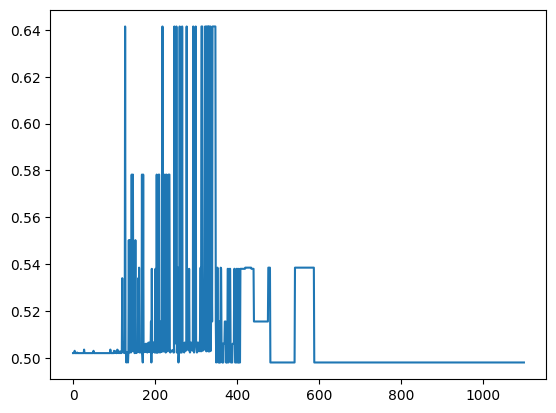

In [16]:
losses = []
for elem in history:
    losses.append(elem[-1])
plt.plot(np.arange(len(losses)),losses);

In [17]:
print(pool)

Pool(
scalars=[1.24302029 0.7760893  1.39848913 1.24302029], 
vectors=
[[0.93400805 0.60880971]
 [0.93400805 0.60880971]
 [0.93400805 0.60880971]
 [0.93400805 0.60880971]]
)
